In [1]:
import sys
import os

# Get the root directory
root_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the root directory to the Python path
sys.path.append(root_dir)

In [2]:
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import OneCycleLR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from vit_pytorch.vit import ViT
from kan import *


import time
import gc
import copy
import traceback
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import torch.optim as optim
import torch

In [3]:
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

print(device)

cuda


In [4]:
SEED = 381
# SET RANDOM SEED FOR REPRODUCIBILITY
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

In [5]:
folder="data/1000-Cameras-Dataset"
x_col=["Release_date", "Max_resolution", "Low_resolution", "Effective_pixels", "Zoom", "Normal_focus_range", "Macro_focus_range", "Storage_included","Weight","Dimensions"]
target_col=["price"]

In [6]:
def load_and_fill_missing(npy_filename, y_filename, x_col, target_col, global_means):
    """
    Load the feature array (npy_filename) and label array (y_filename),
    and fill missing values using global means.
    """
    # Load numpy arrays
    X = np.load(os.path.join(folder, npy_filename))
    y = np.load(os.path.join(folder, y_filename))
    
    # Ensure the number of rows matches between X and y
    if X.shape[0] != y.shape[0]:
        raise ValueError("The number of rows in {} and {} do not match.".format(npy_filename, y_filename))
    
    # Convert arrays to DataFrames
    df_X = pd.DataFrame(X, columns=x_col)
    df_y = pd.DataFrame(y, columns=target_col)
    
    # Fill missing values using global means
    for col in df_X.columns:
        if df_X[col].dtype in [np.float64, np.int64]:  # Numerical columns
            df_X[col] = df_X[col].fillna(global_means[col])
        else:  # Categorical or non-numeric columns
            df_X[col].fillna("_new_", inplace=True)
    
    return df_X, df_y

# Load all datasets
X_train = np.load(os.path.join(folder, 'N_train.npy'))
y_train = np.load(os.path.join(folder, 'y_train.npy'))
X_test = np.load(os.path.join(folder, 'N_test.npy'))
y_test = np.load(os.path.join(folder, 'y_test.npy'))
X_val = np.load(os.path.join(folder, 'N_val.npy'))
y_val = np.load(os.path.join(folder, 'y_val.npy'))

# Combine all feature data for mean computation
df_X_all = pd.DataFrame(np.vstack((X_train, X_test, X_val)), columns=x_col)

global_means = df_X_all.mean()

# Apply missing value imputation
X_train, y_train = load_and_fill_missing('N_train.npy', 'y_train.npy', x_col, target_col, global_means)
X_test, y_test = load_and_fill_missing('N_test.npy', 'y_test.npy', x_col, target_col, global_means)
X_val, y_val = load_and_fill_missing('N_val.npy', 'y_val.npy', x_col, target_col, global_means)

In [7]:
X_train = pd.concat([X_train, y_train], axis=1)
X_test = pd.concat([X_test, y_test], axis=1)
X_val = pd.concat([X_val, y_val], axis=1)

In [8]:
def load_and_preprocess_data(X_train, X_test, X_val, images_folder, image_model, problem_type, batch_size=32, device='cuda'):
    """Loads, processes, and converts a dataset into PyTorch DataLoaders for a ViT + KAN model."""
    
    # Reset indices
    data_splits = {
        "train": X_train.reset_index(drop=True), 
        "val": X_val.reset_index(drop=True), 
        "test": X_test.reset_index(drop=True)
    }
    
    # Process images and numerical features
    num_features, img_paths, targets = {}, {}, {}

    for split, X_split in data_splits.items():
        split_folder = f"{images_folder}/{split}"
        os.makedirs(split_folder, exist_ok=True)

        # Ensure images and CSV files are generated
        image_model.fit_transform(X_split, split_folder) if split == "train" else image_model.transform(X_split, split_folder)

        # Validate CSV file existence
        csv_path = os.path.join(split_folder, f"{problem_type}.csv")
        if not os.path.exists(csv_path):
            print(f"Error: Missing CSV at {csv_path}. Available files: {os.listdir(split_folder)}")
            raise FileNotFoundError(f"Expected file {csv_path} not found. Ensure image_model generates it.")

        print(f"Loading {csv_path}...")
        img_df = pd.read_csv(csv_path)
        img_df["images"] = split_folder + "/" + img_df["images"]

        # Combine numerical data and images
        combined_df = pd.concat([img_df, X_split], axis=1)
        num_features[split] = combined_df.drop(columns=["values", "images", X_train.columns[-1]])
        img_paths[split] = img_df["images"]
        targets[split] = combined_df["values"]

    # Standardize numerical data
    scaler = StandardScaler()
    for split in ["train", "val", "test"]:
        num_features[split] = pd.DataFrame(scaler.fit_transform(num_features[split]) if split == "train" 
                                           else scaler.transform(num_features[split]), 
                                           columns=num_features[split].columns)

    # Convert images to tensors
    img_tensors = {split: torch.tensor(np.array([cv2.imread(img) for img in img_paths[split]]), 
                                       dtype=torch.float32, device=device).permute(0, 3, 1, 2) / 255.0
                   for split in ["train", "val", "test"]}
    
    # Get dataset properties
    attributes = num_features["train"].shape[1]
    channels, height, width = img_tensors["train"].shape[1:]
    imgs_shape = (channels, height, width)

    print("Images shape:", imgs_shape)
    print("Attributes:", attributes)

    # Convert numerical data and targets to tensors
    num_tensors = {split: torch.tensor(num_features[split].values, dtype=torch.float32, device=device)
                   for split in ["train", "val", "test"]}
    
    target_tensors = {split: torch.tensor(targets[split].values, dtype=torch.float32, device=device).reshape(-1, 1)
                      for split in ["train", "val", "test"]}

    # Create DataLoaders
    datasets = {split: TensorDataset(num_tensors[split], img_tensors[split], target_tensors[split]) 
                for split in ["train", "val", "test"]}
    
    data_loaders = {split: DataLoader(datasets[split], batch_size=batch_size, shuffle=(split == "train")) 
                    for split in ["train", "val", "test"]}

    return data_loaders["train"], data_loaders["val"], data_loaders["test"], attributes, imgs_shape

In [9]:
# Get the shape of the dataframe
num_columns = X_train.shape[1]

# Calculate number of columns - 1
columns_minus_one = num_columns - 1

# Calculate the square root for image size
import math
image_size = math.ceil(math.sqrt(columns_minus_one))
print(image_size)

4


In [10]:
from TINTOlib.igtd import IGTD
dataset_name = '1000cameras'
#Select the model and the parameters
problem_type = "regression"
image_model = IGTD(problem= problem_type, scale=[image_size,image_size], fea_dist_method='Euclidean', image_dist_method='Euclidean', error='abs', max_step=30000, val_step=300, random_seed=SEED)
name = f"IGTD_{image_size}x{image_size}_fEuclidean_iEuclidean_abs"

#Define the dataset path and the folder where the images will be saved
images_folder = f"HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [11]:
train_loader, val_loader, test_loader, attributes, imgs_shape = load_and_preprocess_data(
    X_train, X_test, X_val,
    images_folder=images_folder,
    image_model=image_model,
    problem_type=problem_type,
    batch_size=16
)

Loading HyNNImages/Regression/1000cameras/images_1000cameras_IGTD_4x4_fEuclidean_iEuclidean_abs/train\regression.csv...
Loading HyNNImages/Regression/1000cameras/images_1000cameras_IGTD_4x4_fEuclidean_iEuclidean_abs/val\regression.csv...
Loading HyNNImages/Regression/1000cameras/images_1000cameras_IGTD_4x4_fEuclidean_iEuclidean_abs/test\regression.csv...
Images shape: (3, 4, 4)
Attributes: 10


In [12]:
class Model1(nn.Module):
    def __init__(self, attributes, imgs_shape, device):
        super(Model1, self).__init__()
        self.device = device
        # KAN branch
        self.m_kan = KAN(
            width=[attributes, 25, 6],
            grid=3,
            k=3,
            seed=SEED,
            device=device
        )
        
        # CNN branch
        self.cnn_branch = nn.Sequential(
            nn.Conv2d(imgs_shape[0], 16, kernel_size=2),
            nn.ReLU(),
            nn.Flatten()
        ).to(device)
        
        # Calculate the size of the flattened CNN output
        self.cnn_output_size = 16 * (imgs_shape[1] - 1) * (imgs_shape[2] - 1)
        
        # Final MLP layers
        self.final_kan = KAN(
            width=[self.cnn_output_size + 6, 1],
            grid=3,
            k=3,
            seed=SEED,
            device=device
        )


    def forward(self, mlp_input, cnn_input):
        # Ensure inputs are moved to the correct device
        kan_input = mlp_input.to(self.device)
        cnn_input = cnn_input.to(self.device)
        
        cnn_output = self.cnn_branch(cnn_input)  # Process image input
        kan_output = self.m_kan(kan_input)  # Process numerical input
        
        concat_output = torch.cat((kan_output, cnn_output), dim=1)
        return self.final_kan(concat_output)

In [13]:
def try_create_model(model_class, attributes, imgs_shape, device):
    try:
        model = model_class(attributes, imgs_shape, device)
        
        # Test the model with a sample input
        num_input = torch.randn(4, attributes)
        img_input = torch.randn(4, *imgs_shape)
        output = model(num_input, img_input)
        
        print(f"Successfully created and tested {model_class.__name__}")
        
        return model
    except Exception as e:
        print(f"Error creating or testing {model_class.__name__}: {str(e)}")
        traceback.print_exc()
        return None

In [14]:
model1 = try_create_model(Model1, attributes, imgs_shape, device)  # Attempt to create Model1

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model1


In [15]:
def calculate_metrics(model, data_loader, device):
    model.eval()
    loss_fn = nn.MSELoss()
    total_loss = 0
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for num_data, img_data, targets in data_loader:
            num_data, img_data, targets = num_data.to(device, non_blocking=True), img_data.to(device, non_blocking=True), targets.to(device, non_blocking=True)
            outputs = model(num_data, img_data)
            loss = loss_fn(outputs, targets)
            total_loss += loss.item()
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(outputs.cpu().numpy())

    all_targets = np.array(all_targets)
    all_predictions = np.array(all_predictions)

    mse = mean_squared_error(all_targets, all_predictions)
    mae = mean_absolute_error(all_targets, all_predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(all_targets, all_predictions)

    return {
        'loss': total_loss / len(data_loader),
        'mse': mse,
        'mae': mae,
        'rmse': rmse,
        'r2': r2
    }

In [16]:
def combine_loader(loader):
    """
    Combines all batches from a DataLoader into three tensors.
    Assumes each batch is a tuple: (mlp_tensor, img_tensor, target_tensor)
    """
    mlp_list, img_list, target_list = [], [], []
    for mlp, img, target in loader:
        mlp_list.append(mlp)
        img_list.append(img)
        target_list.append(target)
    return torch.cat(mlp_list, dim=0), torch.cat(img_list, dim=0), torch.cat(target_list, dim=0)

In [18]:
import os
import time
import copy
import numpy as np
import torch
import torch.optim as optim
from torch.optim import LBFGS
from tqdm import tqdm
import matplotlib.pyplot as plt

def fit_hybrid_dataloaders(model, 
                           dataset,
                           opt="Adam", 
                           steps=100, 
                           log=1, 
                           lamb=0., 
                           lamb_l1=1., 
                           lamb_entropy=2., 
                           lamb_coef=0., 
                           lamb_coefdiff=0., 
                           update_grid=True, 
                           grid_update_num=10, 
                           loss_fn=None, 
                           lr=1., 
                           start_grid_update_step=-1, 
                           stop_grid_update_step=50, 
                           batch=-1,
                           metrics=None, 
                           save_fig=False, 
                           in_vars=None, 
                           out_vars=None, 
                           beta=3, 
                           save_fig_freq=1, 
                           img_folder='./video', 
                           singularity_avoiding=False, 
                           y_th=1000., 
                           reg_metric='edge_forward_spline_n', 
                           display_metrics=None):
    """
    Trains the hybrid model (with a KAN branch and a CNN branch) using a steps-based loop
    adapted from KAN.fit(), with grid updates and regularization.
    
    Instead of a single dataset dict, this function accepts three DataLoaders:
        - train_loader: provides (mlp, img, target) for training
        - val_loader: provides (mlp, img, target) for validation
        - test_loader: provides (mlp, img, target) for evaluation during training

    Internally, the function combines each loader into a dataset dictionary.
    
    Returns:
        results: dictionary containing training loss, evaluation loss, regularization values,
                 and any additional metrics recorded during training.
    """
    device = next(model.parameters()).device

    # Warn if regularization is requested but model's internal flag isn't enabled.
    if lamb > 0. and not getattr(model.m_kan, "save_act", False):
        print("setting lamb=0. If you want to set lamb > 0, set model.m_kan.save_act=True")
    
    # Disable symbolic processing for training if applicable (KAN internal logic)
    if hasattr(model.m_kan, "disable_symbolic_in_fit"):
        old_save_act, old_symbolic_enabled = model.m_kan.disable_symbolic_in_fit(lamb)
    else:
        old_save_act, old_symbolic_enabled = None, None

    pbar = tqdm(range(steps), desc='Training', ncols=100)

    # Default loss function (mean squared error) if not provided
    if loss_fn is None:
        loss_fn = lambda x, y: torch.mean((x - y) ** 2)

    # Determine grid update frequency
    grid_update_freq = int(stop_grid_update_step / grid_update_num) if grid_update_num > 0 else 1

    # Determine total number of training examples
    n_train = dataset["train_mlp"].shape[0]
    n_eval  = dataset["test_mlp"].shape[0]  # using test set for evaluation during training
    batch_size = n_train if batch == -1 or batch > n_train else batch

    # Set up optimizer: choose between Adam and LBFGS (removed tolerance_ys)
    if opt == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif opt == "LBFGS":
        optimizer = LBFGS(model.parameters(), lr=lr, history_size=10, 
                          line_search_fn="strong_wolfe", 
                          tolerance_grad=1e-32, 
                          tolerance_change=1e-32)
    else:
        raise ValueError("Optimizer not recognized. Use 'Adam' or 'LBFGS'.")

    # Prepare results dictionary.
    results = {
        'train_loss': [],
        'eval_loss': [],
        'reg': []
    }
    if metrics is not None:
        for metric in metrics:
            results[metric.__name__] = []

    for step in pbar:
        # Randomly sample indices for a mini-batch from the training set.
        train_indices = np.random.choice(n_train, batch_size, replace=False)
        # Use full evaluation set for evaluation; you can also sample if desired.
        eval_indices = np.arange(n_eval)

        # Closure for LBFGS
        def closure():
            optimizer.zero_grad()
            mlp_batch = dataset["train_mlp"][train_indices]
            img_batch = dataset["train_img"][train_indices]
            target_batch = dataset["train_target"][train_indices]
            outputs = model(mlp_batch, img_batch)
            train_loss = loss_fn(outputs, target_batch)
            # Compute regularization term if enabled.
            if hasattr(model.m_kan, "save_act") and model.m_kan.save_act:
                if reg_metric == 'edge_backward':
                    model.m_kan.attribute()
                if reg_metric == 'node_backward':
                    model.m_kan.node_attribute()
                reg_val_inner = model.m_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
            else:
                reg_val_inner = torch.tensor(0., device=device)
            loss_val_inner = train_loss + lamb * reg_val_inner
            loss_val_inner.backward()
            return loss_val_inner

        # Perform grid update if applicable.
        if (step % grid_update_freq == 0 and step < stop_grid_update_step 
            and update_grid and step >= start_grid_update_step):
            model.m_kan.update_grid(dataset["train_mlp"][train_indices])

        # Perform an optimizer step.
        if opt == "LBFGS":
            optimizer.step(closure)
            loss_val = closure()  # re-evaluate to record loss
            # Compute reg_val separately for logging
            with torch.no_grad():
                mlp_batch = dataset["train_mlp"][train_indices]
                img_batch = dataset["train_img"][train_indices]
                target_batch = dataset["train_target"][train_indices]
                outputs = model(mlp_batch, img_batch)
                train_loss = loss_fn(outputs, target_batch)
                if hasattr(model.m_kan, "save_act") and model.m_kan.save_act:
                    if reg_metric == 'edge_backward':
                        model.m_kan.attribute()
                    if reg_metric == 'node_backward':
                        model.m_kan.node_attribute()
                    reg_val = model.m_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
                else:
                    reg_val = torch.tensor(0., device=device)
        else:  # Adam branch
            optimizer.zero_grad()
            mlp_batch = dataset["train_mlp"][train_indices]
            img_batch = dataset["train_img"][train_indices]
            target_batch = dataset["train_target"][train_indices]
            outputs = model(mlp_batch, img_batch)
            train_loss = loss_fn(outputs, target_batch)
            if hasattr(model.m_kan, "save_act") and model.m_kan.save_act:
                if reg_metric == 'edge_backward':
                    model.m_kan.attribute()
                if reg_metric == 'node_backward':
                    model.m_kan.node_attribute()
                reg_val = model.m_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
            else:
                reg_val = torch.tensor(0., device=device)
            loss_val = train_loss + lamb * reg_val
            loss_val.backward()
            optimizer.step()

        # Evaluate on the entire evaluation set (from test_loader)
        mlp_eval = dataset["test_mlp"][eval_indices]
        img_eval = dataset["test_img"][eval_indices]
        target_eval = dataset["test_target"][eval_indices]
        eval_loss = loss_fn(model(mlp_eval, img_eval), target_eval)

        # Record results (using square-root of loss similar to KAN.fit)
        results['train_loss'].append(torch.sqrt(loss_val.detach()).item())
        results['eval_loss'].append(torch.sqrt(eval_loss.detach()).item())
        results['reg'].append(reg_val.detach().item())

        if metrics is not None:
            for metric in metrics:
                # Here, we assume each metric returns a tensor.
                results[metric.__name__].append(metric().item())

        # Update progress bar.
        if display_metrics is None:
            pbar.set_description("| train_loss: %.2e | eval_loss: %.2e | reg: %.2e |" %
                                 (torch.sqrt(loss_val.detach()).item(),
                                  torch.sqrt(eval_loss.detach()).item(),
                                  reg_val.detach().item()))
        else:
            desc = ""
            data = []
            for metric in display_metrics:
                desc += f" {metric}: %.2e |"
                data.append(results[metric.__name__][-1])
            pbar.set_description(desc % tuple(data))

        # Optionally save a figure snapshot.
        if save_fig and step % save_fig_freq == 0:
            save_act_backup = getattr(model.m_kan, "save_act", False)
            model.m_kan.save_act = True
            model.plot(folder=img_folder, in_vars=in_vars, out_vars=out_vars, title=f"Step {step}", beta=beta)
            plt.savefig(os.path.join(img_folder, f"{step}.jpg"), bbox_inches='tight', dpi=200)
            plt.close()
            model.m_kan.save_act = save_act_backup

    # Restore original settings if applicable.
    if old_symbolic_enabled is not None:
        model.m_kan.symbolic_enabled = old_symbolic_enabled
    if hasattr(model.m_kan, "log_history"):
        model.m_kan.log_history('fit')

    return results


In [19]:
# Combine dataloaders into tensors.
train_mlp, train_img, train_target = combine_loader(train_loader)
val_mlp, val_img, val_target = combine_loader(val_loader)
test_mlp, test_img, test_target = combine_loader(test_loader)

dataset = {
    "train_mlp": train_mlp.to(device),
    "train_img": train_img.to(device),
    "train_target": train_target.to(device),
    "val_mlp": val_mlp.to(device),
    "val_img": val_img.to(device),
    "val_target": val_target.to(device),
    "test_mlp": test_mlp.to(device),
    "test_img": test_img.to(device),
    "test_target": test_target.to(device),
}

In [20]:
model1 = try_create_model(Model1, attributes, imgs_shape, device)  # Attempt to create Model1
metrics = fit_hybrid_dataloaders(model1, dataset, opt="Adam", steps=100, lamb=0.1, lamb_entropy=10.)

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model1


| train_loss: 3.76e+02 | eval_loss: 4.80e+02 | reg: 2.70e+03 |: 100%|█| 100/100 [01:43<00:00,  1.04s

saving model version 0.1


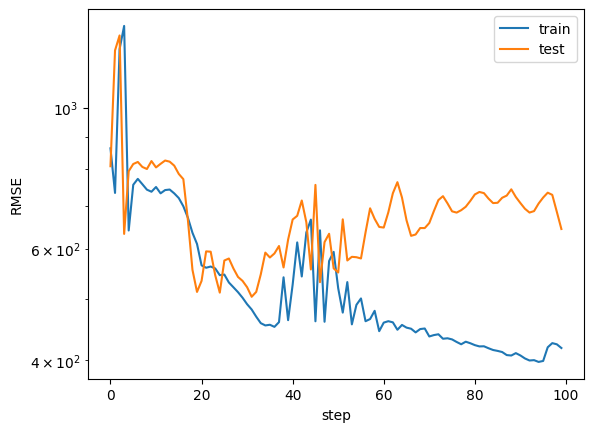

In [36]:
plt.plot(metrics['train_loss'])
plt.plot(metrics['eval_loss'])
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

In [28]:
model1 = try_create_model(Model1, attributes, imgs_shape, device)  # Attempt to create Model1
metrics = fit_hybrid_dataloaders(model1, dataset, opt="Adam", steps=70, lamb=0.1, lamb_entropy=10., update_grid=False)

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model1


| train_loss: 4.24e+02 | eval_loss: 5.20e+02 | reg: 2.45e+03 |: 100%|█| 70/70 [00:10<00:00,  6.60it/

saving model version 0.1


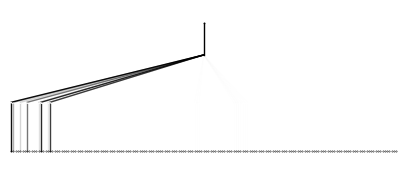

In [24]:
model1.final_kan.plot()

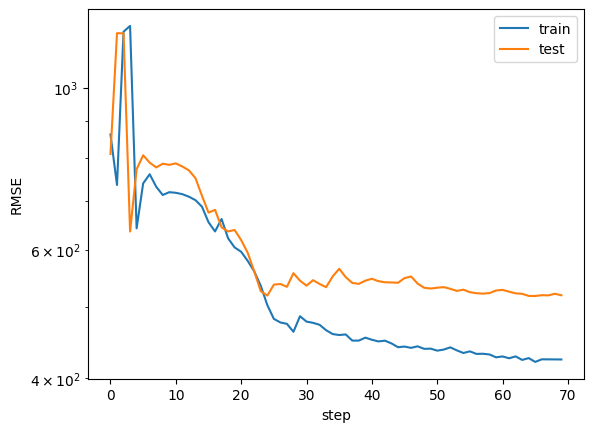

In [29]:
plt.plot(metrics['train_loss'])
plt.plot(metrics['eval_loss'])
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

In [48]:
class Model2(nn.Module):
    def __init__(self, attributes, imgs_shape, device):
        super(Model2, self).__init__()
        self.device = device
        # KAN branch
        self.m_kan = KAN(
            width=[attributes, 25, 6],
            grid=3,
            k=3,
            seed=SEED,
            device=device
        )
        
        # CNN branch
        self.cnn_branch = nn.Sequential(
            nn.Conv2d(imgs_shape[0], out_channels=16, kernel_size=2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        ).to(device)

        # Calculate the size of the flattened output
        self.flat_size = self._get_flat_size(imgs_shape)

        # Final MLP layers
        self.final_kan = KAN(
            width=[self.flat_size + 6, 1],
            grid=3,
            k=3,
            seed=SEED,
            device=device
        )

    def _get_flat_size(self, imgs_shape):
        # Forward pass with dummy input to calculate flat size
        dummy_cnn_input = torch.zeros(1, *imgs_shape, device=device)
        cnn_output = self.cnn_branch(dummy_cnn_input)
        
        return cnn_output.size(1)


    def forward(self, mlp_input, cnn_input):
        # Ensure inputs are moved to the correct device
        kan_input = mlp_input.to(self.device)
        cnn_input = cnn_input.to(self.device)
        
        cnn_output = self.cnn_branch(cnn_input)  # Process image input
        kan_output = self.m_kan(kan_input)  # Process numerical input
        
        concat_output = torch.cat((kan_output, cnn_output), dim=1)
        return self.final_kan(concat_output)

In [49]:
model2 = try_create_model(Model2, attributes, imgs_shape, device)  # Attempt to create Model1

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model2


| train_loss: 9.13e+02 | eval_loss: 7.29e+02 | reg: 1.71e+03 |: 100%|█| 80/80 [00:44<00:00,  1.81it/

saving model version 0.1


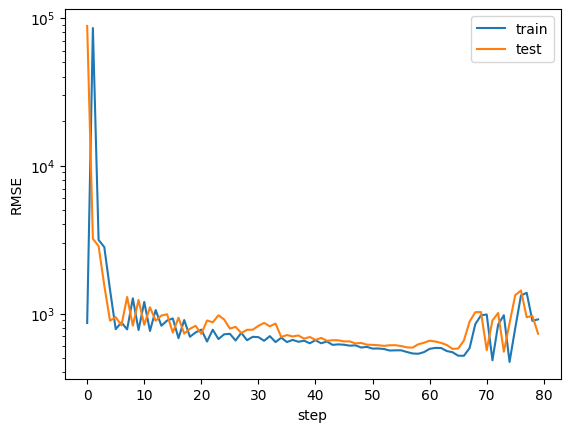

In [50]:
metrics = fit_hybrid_dataloaders(model2, dataset, opt="Adam", steps=80, lamb=0.1, lamb_entropy=10.)
plt.plot(metrics['train_loss'])
plt.plot(metrics['eval_loss'])
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

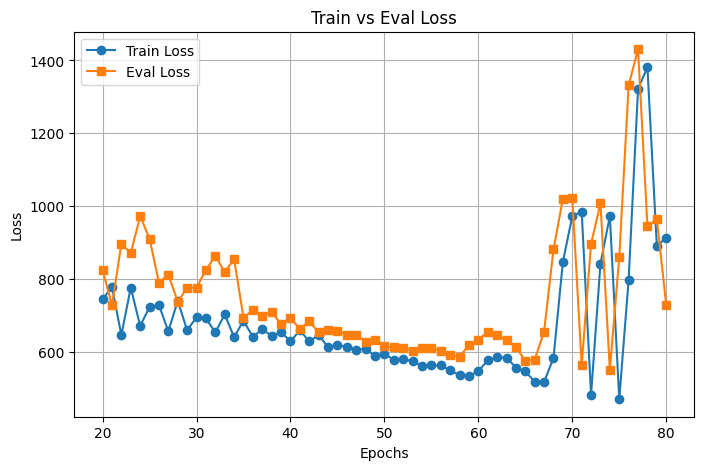

In [51]:

epochs = range(20, len(metrics['train_loss']) + 1)
plt.figure(figsize=(8, 5))
plt.plot(epochs, metrics['train_loss'][19:], label='Train Loss', marker='o', linestyle='-')
plt.plot(epochs, metrics['eval_loss'][19:], label='Eval Loss', marker='s', linestyle='-')

# Labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Eval Loss')
plt.legend()
plt.grid(True)

# Show plot
plt.show()